# One-hot HMM-GLM on the CRCRS pfc-6 Dataset

![](../assets/schematic.png)

## 1 Load the dataset

In [238]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from hmmglm.models import naive, onehot
from hmmglm import distributions, inference, utils

In [103]:
def load_data(dt: float = 20, T: float = 15000):
    n_time_bins = int(T / dt)
    session = "200104"
    behavior = pd.read_csv(
        f"../data/{session}/{session}_Behavior.dat",
        sep="\t",
        header=None,
    )
    behavior.columns = [
        "trial_start_time",
        "trial_end_time",
        "rule",
        "outcome",
        "choice",
        "light_position",
    ]
    behavior.replace(
        {
            "rule": {
                1: "go right",
                2: "go light",
                3: "go left",
                4: "go dark",
            },
            "outcome": {1: "correct", 0: "incorrect"},
            "choice": {1: "left", 0: "right"},
            "light_position": {1: "left", 0: "right"},
        },
        inplace=True,
    )

    raw_position = pd.read_table(
        f"../data/{session}/{session}_Pos.dat", header=None
    )
    raw_position.columns = ["time", "x", "y"]
    raw_spike_data = pd.read_table(
        f"../data/{session}/{session}_SpikeData.dat", header=None
    )
    raw_spike_data.columns = ["time", "cell_id"]

    spike_time_by_cell_id = [
        (neuron, i["time"].values)
        for neuron, i in raw_spike_data.groupby("cell_id")
    ]
    n_neurons = len(spike_time_by_cell_id)
    n_trials = len(behavior)

    start_idx_list = np.searchsorted(
        raw_position["time"], behavior["trial_start_time"] - 5000
    )
    end_idx_list = np.searchsorted(
        raw_position["time"], behavior["trial_start_time"] - 5000 + T
    )
    trial_start_idx_list = np.searchsorted(
        raw_position["time"], behavior["trial_start_time"]
    )
    trial_end_idx_list = np.searchsorted(
        raw_position["time"], behavior["trial_end_time"]
    )

    behavior["trajectory"] = None
    behavior["trial_start_position"] = None
    behavior["trial_end_position"] = None
    spikes = torch.zeros((n_trials, n_time_bins, n_neurons))
    for trial in range(n_trials):
        time_bins = np.linspace(
            behavior.at[trial, "trial_start_time"] - 5000,
            behavior.at[trial, "trial_start_time"] - 5000 + T,
            n_time_bins + 1,
        )
        for neuron in range(n_neurons):
            spikes[trial, :, neuron] = torch.tensor(
                np.histogram(
                    spike_time_by_cell_id[neuron][1],
                    bins=time_bins,
                )[0]
            )
        
        behavior.at[trial, "trajectory"] = raw_position.iloc[
            start_idx_list[trial] : end_idx_list[trial]
        ][["time", "x", "y"]].values
        behavior.at[trial, "trial_start_position"] = raw_position.iloc[
            trial_start_idx_list[trial]
        ][["x", "y"]].values
        behavior.at[trial, "trial_end_position"] = raw_position.iloc[
            trial_end_idx_list[trial]
        ][["x", "y"]].values
    spikes = spikes.to(
        torch.float32
    )  # (n_trials, n_time_bins, n_neurons)
    return spikes, behavior

In [29]:
spikes, behavior = load_data()
print(spikes.shape)
behavior.head()

torch.Size([54, 750, 18])


,trial_start_time,trial_end_time,rule,outcome,choice,light_position,trajectory,trial_start_position,trial_end_position
0,1968759.3,1971595.3,go dark,incorrect,left,left,"[[1963787.9, 173.2, 187.2], [1963821.3, 173.0,...","[169.4, 134.2]","[257.1, 49.1]"
1,1993249.2,1996285.4,go dark,incorrect,left,left,"[[1988277.8, 155.8, 163.1], [1988311.2, 155.9,...","[168.1, 135.9]","[254.9, 47.9]"
2,2005927.9,2014169.0,go dark,incorrect,left,left,"[[2000956.5, 147.1, 92.3], [2000989.9, 146.5, ...","[176.1, 204.8]","[254.0, 46.1]"
3,2023611.3,2033854.4,go dark,correct,left,right,"[[2018639.9, 119.3, 81.6], [2018673.3, 118.8, ...","[182.4, 184.7]","[255.8, 46.2]"
4,2093010.5,2096880.8,go dark,incorrect,left,left,"[[2088039.1, 173.8, 192.2], [2088072.5, 174.6,...","[152.9, 129.2]","[255.1, 44.4]"


## 2 Configure the One-hot HMM-GLM

In [301]:
n_trials, n_time_bins, n_neurons = spikes.shape
n_states = 4
kernel_size = 5

In [319]:
# decoder = onehot.OneHotHMMGLM(
#     n_states=n_states,
#     n_neurons=n_neurons,
#     kernel_size=kernel_size,
#     activation="softplus",  # or "sigmoid", etc
#     share_bias=False,  # 4 states share the same bias vector
#     share_kernel=True,  # 4 states share the same kernel
#     diag_setting="none",  # don't treat diagonal elements differently
#     adjacency_distribution="categorical",  # or "gumbel-softmax"
#     adjacency_exists=True,  # adjacency is the one-hot encoding of [inh, no, exc] rather than [inh, exc]
# )

decoder = onehot.OneHotHMMGLM(
    n_states=n_states,
    n_neurons=n_neurons,
    kernel_size=kernel_size,
    activation="softplus",  # or "sigmoid", etc
    share_bias=False,
    share_kernel=False,
    diag_setting="free",  # don't treat diagonal elements differently
    adjacency_distribution="categorical",  # or "gumbel-softmax"
    adjacency_exists=True,  # adjacency is the one-hot encoding of [inh, no, exc] rather than [inh, exc]
)

Let's also fix the convolution kernel for simplicity.

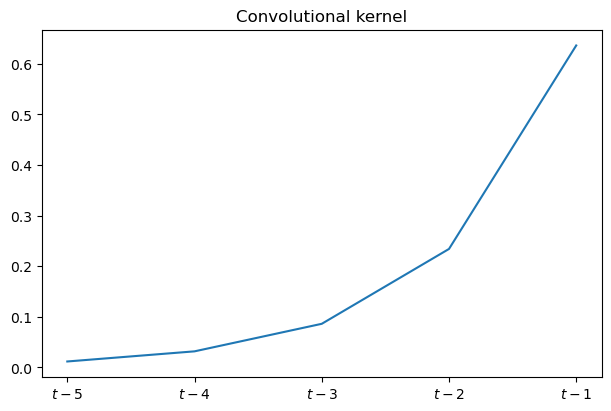

In [303]:
kernel = torch.exp(-torch.arange(5)).flip(dims=(-1,))
kernel = kernel / kernel.sum()
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")
ax.plot(kernel)
ax.set(
    xticks=[0, 1, 2, 3, 4],
    xticklabels=["$t-5$", "$t-4$", "$t-3$", "$t-2$", "$t-1$"],
    title="Convolutional kernel",
)

kernel = kernel.unsqueeze(0).unsqueeze(0).expand_as(decoder.conv_weight).contiguous()  # (shared across states, n_neurons, n_neurons, kernel_size)
decoder.conv_weight = kernel  # set the kernel
decoder.parametrizations.conv_weight.original.requires_grad = False  # freeze the kernel

## 3 Train One-hot HMM-GLM

In [320]:
def train_onehot_hmmglm(
    decoder: onehot.OneHotHMMGLM,
    optimizer: torch.optim.Optimizer,
    spikes: torch.FloatTensor,
    n_epochs: int = 100,
    forward_backward_every_n_epochs: int = 1,
    print_freq: int = 1,
) -> torch.FloatTensor:
    
    n_trials, n_time_bins, n_neurons = spikes.shape

    gamma_list = [None for _ in range(n_trials)]
    xi_list = [None for _ in range(n_trials)]

    df_log = pd.DataFrame(index=range(n_epochs), columns=["loss", "conditional_log_prob", "expected_log_prob", "adjacency_log_prob", "adjacency_entropy"])

    for epoch in range(n_epochs):
        for trial in range(n_trials):
            x = spikes[trial]  # (n_time_bins, n_neurons)
            x_pred_mean = decoder(x)  # (n_states, n_time_bins, n_neurons)
            emission_log_prob = distributions.poisson_log_likelihood(
                x[None, :, :], x_pred_mean
            ).sum(dim=-1).T  # (n_time_bins, n_states)

            if epoch % forward_backward_every_n_epochs == 0:
                gamma_list[trial], xi_list[trial] = inference.forward_backward(
                    emission_log_prob, decoder.transition_matrix, algorithm="logsumexp"
                )
            
            expected_log_prob = (
                    inference.baum_welch(
                    emission_log_prob,
                    decoder.transition_matrix,
                    gamma_list[trial],
                    xi_list[trial],
                )
                / x.shape[0]
            )

            adjacency = decoder.adjacency
            log_adjacency = F.log_softmax(
                decoder.parametrizations["adjacency"].original, dim=-1
            )

            if decoder.adjacency_distribution == "gumbel-softmax":
                logit_adjacency_prior = decoder.logit_adjacency_prior.expand_as(
                    log_adjacency
                )
                adjacency_log_prob = distributions.gumbel_softmax_log_likelihood_log_input(
                    log_adjacency,
                    logit_adjacency_prior,
                    tau=0.5,
                ).sum()
            elif decoder.adjacency_distribution == "categorical":
                log_adjacency_prior = F.log_softmax(
                    decoder.logit_adjacency_prior, dim=-1
                ).expand_as(adjacency)
                adjacency_log_prob = (adjacency * log_adjacency_prior).sum()
            else:
                raise ValueError(
                    f"Invalid adjacency_distribution: {decoder.adjacency_distribution}"
                )
            
            adjacency_entropy = -(adjacency * log_adjacency).sum()

            loss = -expected_log_prob - adjacency_log_prob
            if decoder.adjacency_distribution == "categorical":
                loss += adjacency_entropy
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            df_log.at[epoch, "loss"] = loss.item() / n_trials
            df_log.at[epoch, "conditional_log_prob"] = (
                emission_log_prob[torch.arange(n_time_bins), gamma_list[trial].argmax(dim=-1)].sum().item() / n_trials
            )
            df_log.at[epoch, "expected_log_prob"] = expected_log_prob.item() / n_trials
            df_log.at[epoch, "adjacency_log_prob"] = adjacency_log_prob.item() / n_trials
            df_log.at[epoch, "adjacency_entropy"] = adjacency_entropy.item() / n_trials
        
        decoder.parametrizations["adjacency"].original.data = F.log_softmax(
            decoder.parametrizations["adjacency"].original.data, dim=-1
        ).clamp(-20, 0)
        
        if epoch % print_freq == 0:
            print(epoch, df_log.loc[epoch], flush=True)
    
    return df_log

In [321]:
optimizer = torch.optim.AdamW(
    decoder.parameters(),
    lr=5e-3,
)
n_epochs = 100
forward_backward_every_n_epochs = 4

In [322]:
df_log = train_onehot_hmmglm(
    decoder,
    optimizer,
    spikes,
    n_epochs=n_epochs,
    forward_backward_every_n_epochs=forward_backward_every_n_epochs,
    print_freq=1,
)

0 loss                     51.221879
conditional_log_prob   -131.153791
expected_log_prob        -0.176329
adjacency_log_prob      -25.591829
adjacency_entropy         25.45372
Name: 0, dtype: object
1 loss                     44.371718
conditional_log_prob   -111.938576
expected_log_prob        -0.150683
adjacency_log_prob      -22.311311
adjacency_entropy        21.909724
Name: 1, dtype: object
2 loss                    34.849392
conditional_log_prob   -95.012958
expected_log_prob       -0.127981
adjacency_log_prob     -17.566445
adjacency_entropy       17.154968
Name: 2, dtype: object
3 loss                    26.087344
conditional_log_prob   -85.906259
expected_log_prob       -0.115983
adjacency_log_prob     -13.158678
adjacency_entropy       12.812683
Name: 3, dtype: object
4 loss                     19.99242
conditional_log_prob   -78.467529
expected_log_prob       -0.105753
adjacency_log_prob     -10.118987
adjacency_entropy         9.76768
Name: 4, dtype: object
5 loss         

Text(0.5, 0.01, 'Epoch')

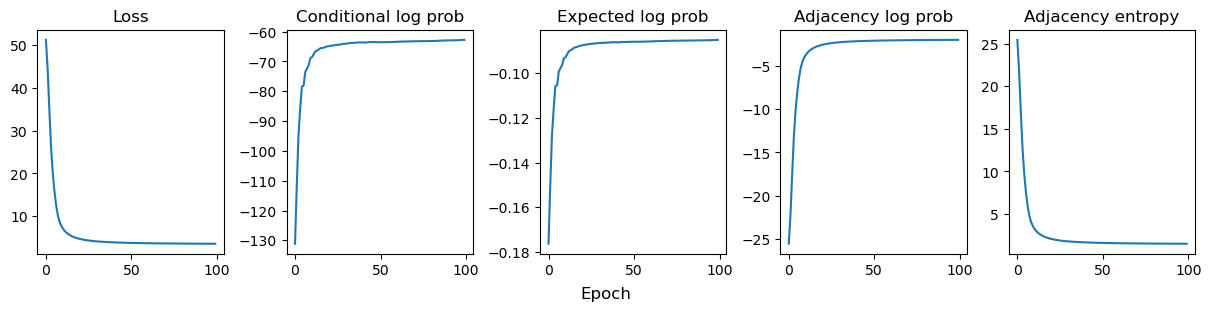

In [323]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), layout="constrained")
axs[0].plot(df_log["loss"])
axs[0].set_title("Loss")
axs[1].plot(df_log["conditional_log_prob"])
axs[1].set_title("Conditional log prob")
axs[2].plot(df_log["expected_log_prob"])
axs[2].set_title("Expected log prob")
axs[3].plot(df_log["adjacency_log_prob"])
axs[3].set_title("Adjacency log prob")
axs[4].plot(df_log["adjacency_entropy"])
axs[4].set_title("Adjacency entropy")
fig.supxlabel("Epoch")

## 4 Check and visualize the result

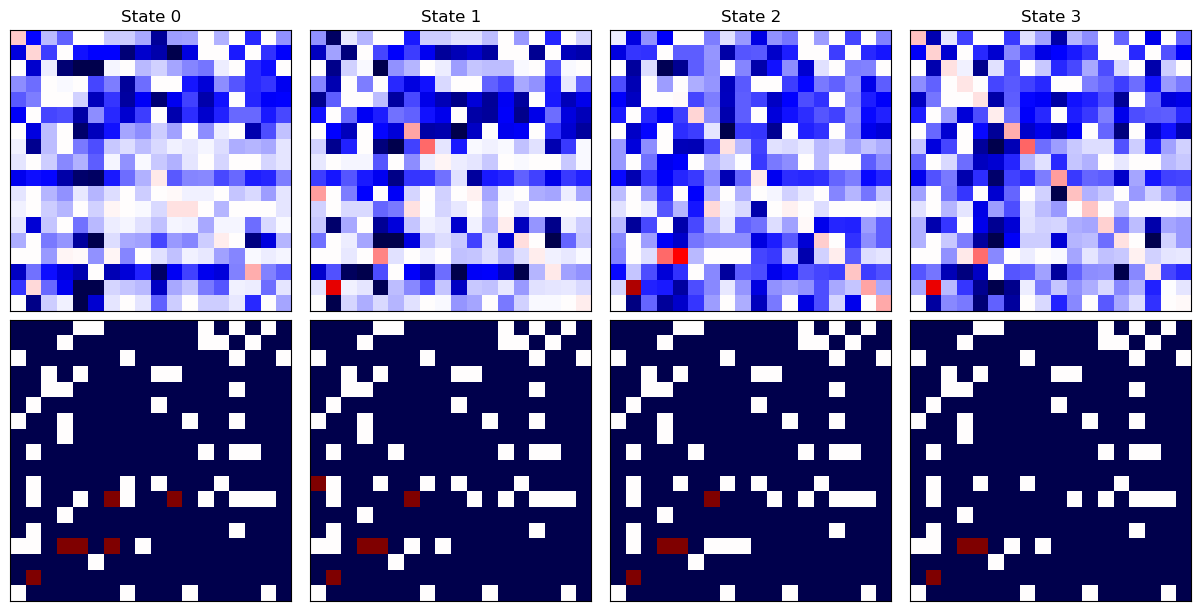

In [330]:
with torch.no_grad():
    decoder.eval()
    weight = decoder.weight
    weight[:, torch.arange(n_neurons), torch.arange(n_neurons)] = (
        decoder.diag.weight.mean(dim=-1).reshape(-1, n_neurons)
    )
    adjacency = decoder.adjacency.argmax(dim=-1) - 1

    fig, axs = plt.subplots(2, 4, figsize=(12, 6), layout="constrained")
    for state in range(n_states):
        ax = axs[0, state]
        ax.matshow(weight[state], vmin=-5, vmax=5, cmap="seismic")
        ax.set_title(f"State {state}")
        ax.set(xticks=[], yticks=[])

        ax = axs[1, state]
        ax.matshow(adjacency[state], vmin=-1, vmax=1, cmap="seismic")
        ax.set(xticks=[], yticks=[])

In [130]:
def plot_frame(ax):
    transform = np.array([[-1 / 2, np.sqrt(3) / 2], [-np.sqrt(3) / 2, -1 / 2]])
    radius = 40
    theta = 210 / 360 * 2 * np.pi
    start = np.array([radius * np.cos(theta), radius * np.sin(theta)])
    arm_length = 125
    theta = 330 / 360 * 2 * np.pi
    end = np.array([radius * np.cos(theta), radius * np.sin(theta)])
    one_arm = np.array(
        [
            [start[0], start[0], end[0], end[0]],
            [start[1], start[1] - arm_length, end[1] - arm_length, end[1]],
        ]
    )
    ax.plot(one_arm[0], one_arm[1], "k")
    one_arm = transform @ one_arm
    ax.plot(one_arm[0], one_arm[1], "k")
    one_arm = transform @ one_arm
    ax.plot(one_arm[0], one_arm[1], "k")

    # ax.text(0, -160, "root", fontsize=15, va="center", ha="center")
    ax.set_xlim(-160, 160)
    ax.set_ylim(-190, 130)
    ax.axis("off")
    ax.set_aspect("equal")


def plot_states(ax, behavior_ser, inferred_states, markersize: int = 6):
    trajectory_time = behavior_ser["trajectory"][:, 0]
    ax.matshow(inferred_states[None, :], vmin=0, vmax=9, cmap="tab10", aspect="auto")
    ax.set(xticks=[], yticks=[])

    if behavior_ser["outcome"] == "correct":
        marker = "*k"
    else:
        marker = "sk"

    trial_start_idx = (
        np.searchsorted(trajectory_time, behavior_ser["trial_start_time"])
        / len(trajectory_time)
        * len(inferred_states)
    )
    trial_end_idx = (
        np.searchsorted(trajectory_time, behavior_ser["trial_end_time"])
        / len(trajectory_time)
        * len(inferred_states)
    )
    ax.plot(trial_start_idx, 0, ">k", markersize=markersize)
    ax.plot(trial_end_idx, 0, marker, markersize=markersize)


def plot_soft_states(ax, behavior_ser, gamma, markersize: int = 6):
    trajectory_time = behavior_ser["trajectory"][:, 0]
    n_states = gamma.shape[1]
    for state in range(n_states):
        ax.matshow(
            state * np.ones((1, gamma.shape[0])),
            vmin=0,
            vmax=9,
            cmap="tab10",
            aspect="auto",
            alpha=gamma[None, :, state],
        )
    ax.set(xticks=[], yticks=[])

    if behavior_ser["outcome"] == "correct":
        marker = "*k"
    else:
        marker = "sk"

    trial_start_idx = (
        np.searchsorted(trajectory_time, behavior_ser["trial_start_time"])
        / len(trajectory_time)
        * len(gamma)
    )
    trial_end_idx = (
        np.searchsorted(trajectory_time, behavior_ser["trial_end_time"])
        / len(trajectory_time)
        * len(gamma)
    )
    ax.plot(trial_start_idx, 0, ">k", markersize=markersize)
    ax.plot(trial_end_idx, 0, marker, markersize=markersize)


def plot_trajectory(
    ax, behavior_ser: pd.Series, inferred_states: torch.Tensor, n_points: int | None = None, truncate: tuple[int|None, int|None] = (0, -1), markersize: int = 10
):
    theta = 185 / 360 * 2 * np.pi
    transform = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )
    translation = np.array([155, 122])
    trial_start_position = behavior_ser["trial_start_position"]
    trial_start_position = transform @ trial_start_position + translation
    ax.plot(
        trial_start_position[0],
        trial_start_position[1],
        ">k",
        markersize=markersize,
    )
    if behavior_ser["outcome"] == "correct":
        marker = "*k"
    else:
        marker = "sk"
    if behavior_ser["light_position"] == "right":
        ax.add_patch(Circle((140, 90), 10, fc="gold", edgecolor="black"))
        ax.add_patch(Wedge((140, 80), 5, 180, 360, fc="none", edgecolor="black"))
    else:
        ax.add_patch(Circle((-140, 90), 10, fc="gold", edgecolor="black"))
        ax.add_patch(Wedge((-140, 80), 6, 180, 360, fc="none", edgecolor="black"))
    trial_end_position = behavior_ser["trial_end_position"]
    trial_end_position = transform @ trial_end_position + translation
    ax.plot(
        trial_end_position[0],
        trial_end_position[1],
        marker,
        markersize=markersize,
    )
    ax.text(0, 90, f"{behavior_ser["rule"]}", fontsize=15, ha="center", va="center")

    trajectory = behavior_ser["trajectory"][:, 1:]

    if n_points is None:
        n_points = min(len(trajectory), len(inferred_states))
    trajectory = trajectory[np.linspace(0, len(trajectory) - 1, n_points, dtype=int)]
    trajectory = trajectory @ transform.T + translation
    inferred_states = inferred_states[
        np.linspace(0, len(inferred_states) - 1, n_points, dtype=int)
    ]
    ax.scatter(
        trajectory[truncate[0]:truncate[1], 0],
        trajectory[truncate[0]:truncate[1], 1],
        c=inferred_states[truncate[0]:truncate[1]],
        vmin=0,
        vmax=9,
        cmap="tab10",
        s=1,
        zorder=10,
    )

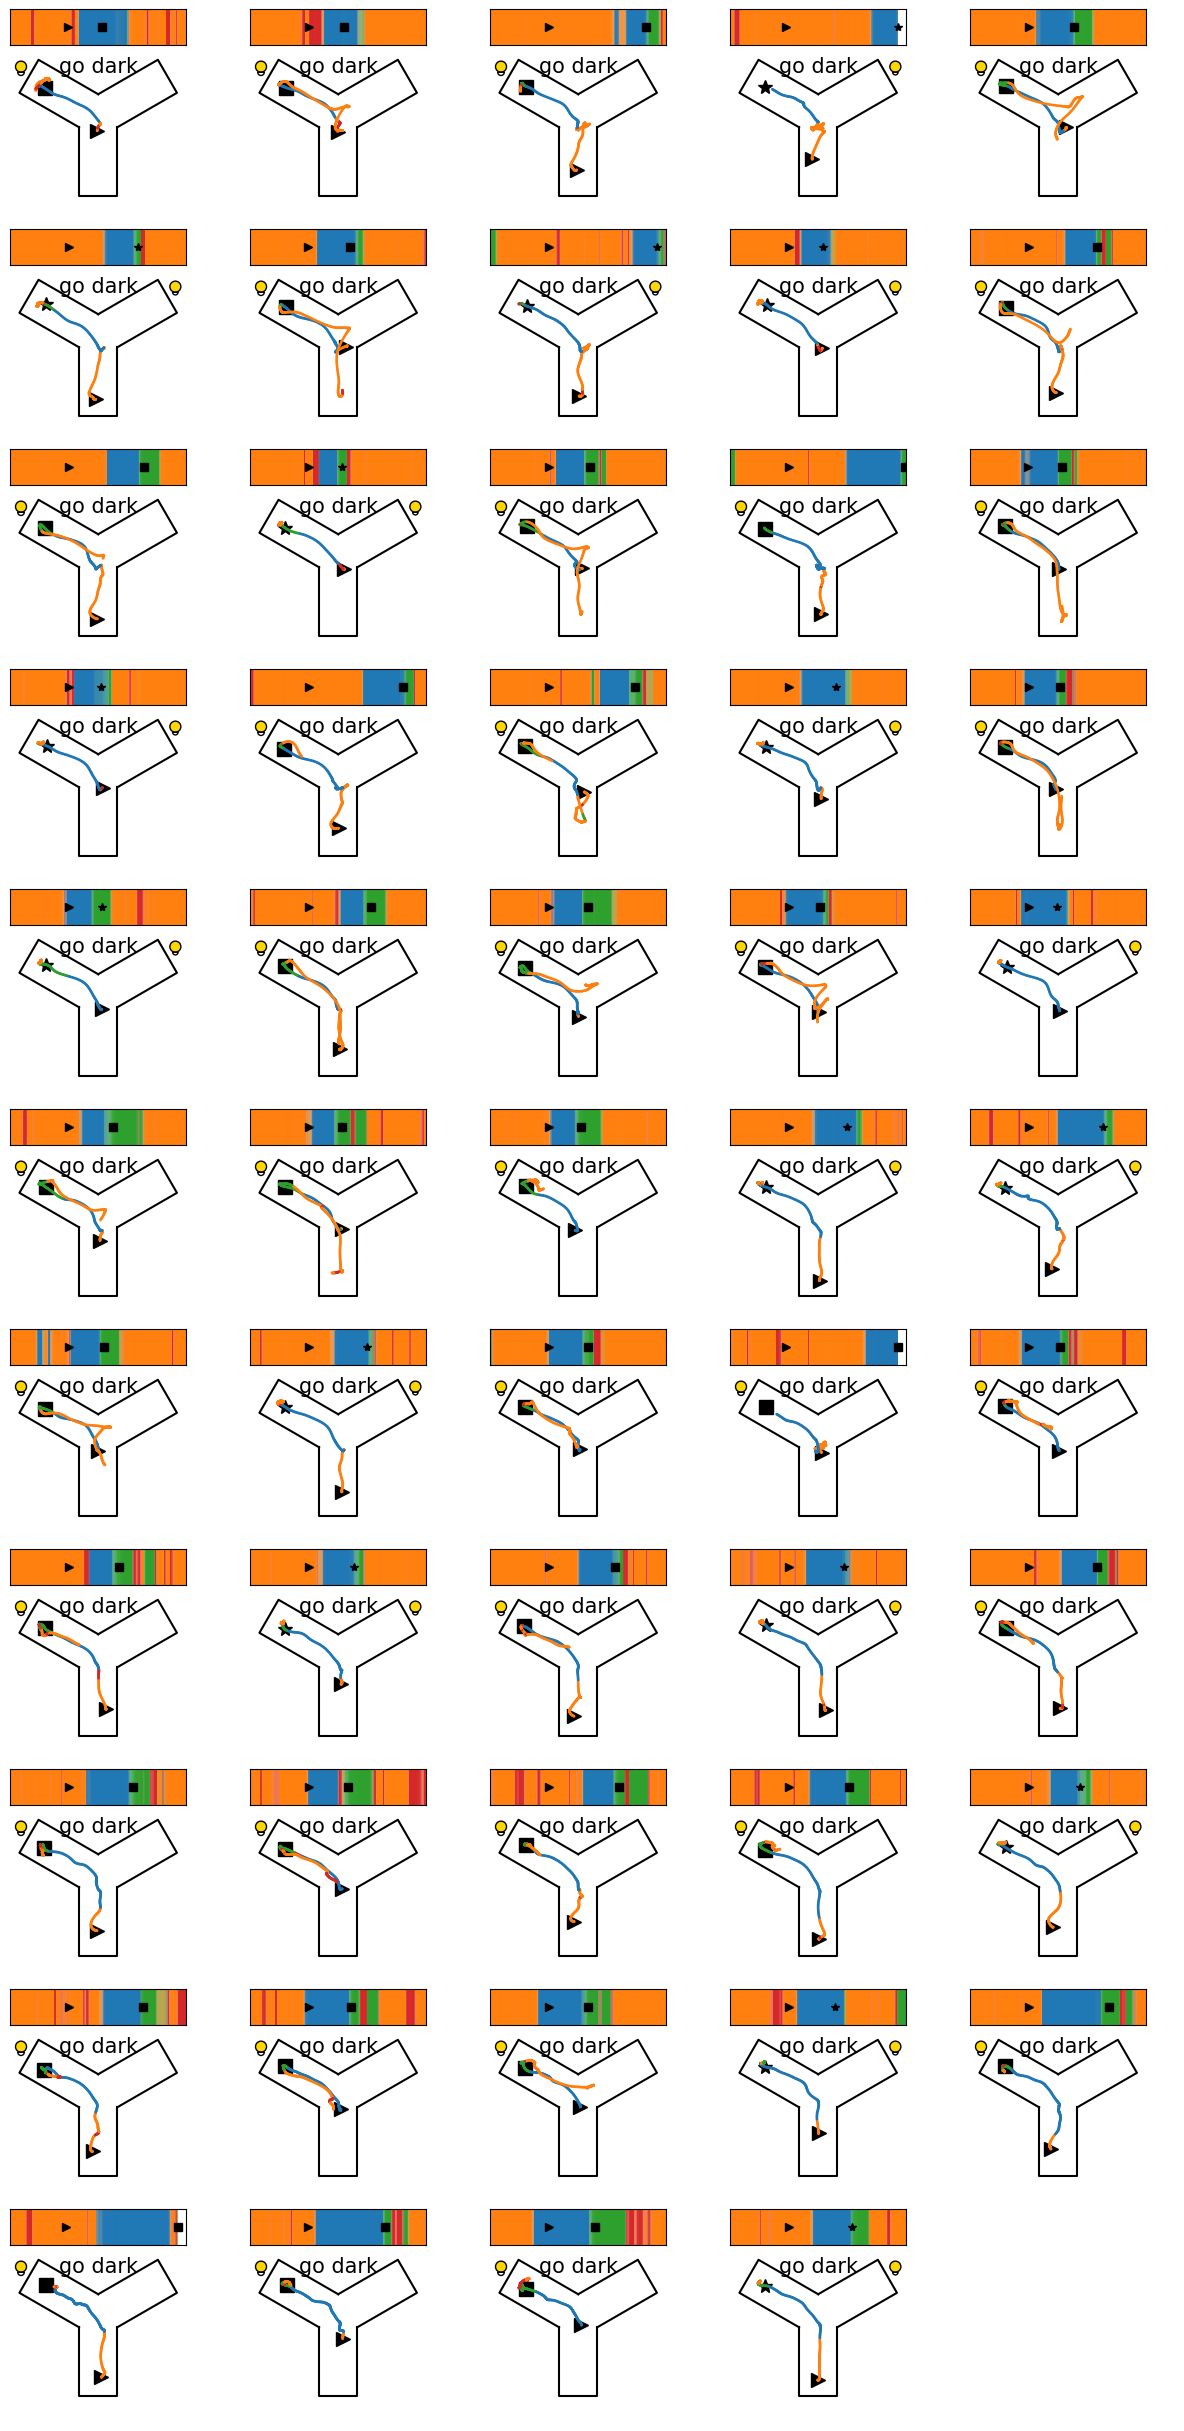

In [331]:
n_rows = (n_trials - 1) // 5 + 1
n_points = 450
fig, axs = plt.subplots(n_rows, 5, figsize=(12, 2.2 * n_rows), layout="constrained")
axs = axs.flatten()

gamma_list = [None for _ in range(n_trials)]
inferred_states_list = [None for _ in range(n_trials)]

with torch.no_grad():
    for trial in range(n_trials):
    # for trial in range(5):
        x = spikes[trial]  # (n_time_bins, n_neurons)
        x_pred_mean = decoder(x)  # (n_states, n_time_bins, n_neurons)
        emission_log_prob = distributions.poisson_log_likelihood(
            x[None, :, :], x_pred_mean
        ).sum(dim=-1).T  # (n_time_bins, n_states)

        gamma_list[trial], _ = inference.forward_backward(
            emission_log_prob, decoder.transition_matrix, algorithm="logsumexp"
        )
        inferred_states_list[trial] = inference.viterbi(
            emission_log_prob, decoder.transition_matrix
        )
        ax = axs[trial]
        plot_frame(ax)
        plot_trajectory(ax, behavior.loc[trial], inferred_states_list[trial], n_points=n_points, truncate=(150, -1))
        ax_divider = make_axes_locatable(ax)
        ax_states = ax_divider.append_axes("top", size="20%", pad=0)
        plot_soft_states(ax_states, behavior.loc[trial], gamma_list[trial])


    for trial in range(n_trials, len(axs)):
        axs[trial].axis("off")

## 5 GLM for comparison

In [353]:
class GLM(nn.Module):
    def __init__(self, n_neurons: int):
        super().__init__()
        self.linear = nn.Linear(n_neurons, n_neurons)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.softplus(self.linear(x))
        # return F.sigmoid(self.linear(x))

In [354]:
def train_glm(
    decoder: GLM,
    optimizer: torch.optim.Optimizer,
    spikes: torch.FloatTensor,
    convolved_spikes: torch.FloatTensor,
    n_epochs: int = 100,
    print_freq: int = 1,
) -> torch.FloatTensor:
    
    n_trials, n_time_bins, n_neurons = spikes.shape

    df_log = pd.DataFrame(index=range(n_epochs), columns=["loss", "conditional_log_prob"])

    for epoch in range(n_epochs):
        for trial in range(n_trials):
            x = spikes[trial]  # (n_time_bins, n_neurons)
            convolved_x = convolved_spikes[trial]  # (n_time_bins, n_neurons)
            x_pred_mean = decoder(convolved_x)  # (n_time_bins, n_neurons)
            emission_log_prob = distributions.poisson_log_likelihood(
                x, x_pred_mean
            ).sum(dim=-1).T  # (n_time_bins)
            emission_log_prob = emission_log_prob.sum()
            
            loss = -emission_log_prob
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            df_log.at[epoch, "loss"] = loss.item() / n_trials
            df_log.at[epoch, "conditional_log_prob"] = emission_log_prob.item() / n_trials
        
        if epoch % print_freq == 0:
            print(epoch, df_log.loc[epoch], flush=True)
    
    return df_log

In [359]:
decoder_glm = GLM(n_neurons)

optimizer = torch.optim.AdamW(
    decoder_glm.parameters(),
    lr=5e-3,
)

n_epochs = 100

# kernel = torch.exp(-torch.arange(5)).flip(dims=(-1,))
# kernel = kernel / kernel.sum()
kernel = torch.exp(-torch.arange(5) / 10).flip(dims=(-1,))
kernel = kernel / (0.02 * kernel.sum())
convolved_spikes = utils.pre_convolve(
    spikes,
    kernel,
)

In [360]:
df_log = train_glm(
    decoder_glm,
    optimizer,
    spikes,
    convolved_spikes,
    n_epochs=n_epochs,
    print_freq=10,
)

0 loss                    101.473796
conditional_log_prob   -101.473796
Name: 0, dtype: object
10 loss                    67.626591
conditional_log_prob   -67.626591
Name: 10, dtype: object
20 loss                    66.173557
conditional_log_prob   -66.173557
Name: 20, dtype: object
30 loss                    65.656363
conditional_log_prob   -65.656363
Name: 30, dtype: object
40 loss                    65.39752
conditional_log_prob   -65.39752
Name: 40, dtype: object
50 loss                    65.2399
conditional_log_prob   -65.2399
Name: 50, dtype: object
60 loss                    65.126483
conditional_log_prob   -65.126483
Name: 60, dtype: object
70 loss                    65.044
conditional_log_prob   -65.044
Name: 70, dtype: object
80 loss                    64.983159
conditional_log_prob   -64.983159
Name: 80, dtype: object
90 loss                    64.940864
conditional_log_prob   -64.940864
Name: 90, dtype: object


Text(0.5, 0.01, 'Epoch')

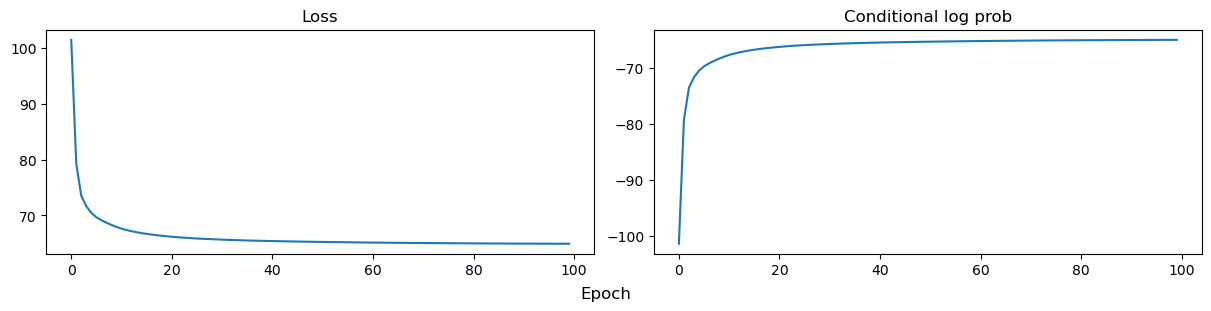

In [361]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3), layout="constrained")
axs[0].plot(df_log["loss"])
axs[0].set_title("Loss")
axs[1].plot(df_log["conditional_log_prob"])
axs[1].set_title("Conditional log prob")
fig.supxlabel("Epoch")

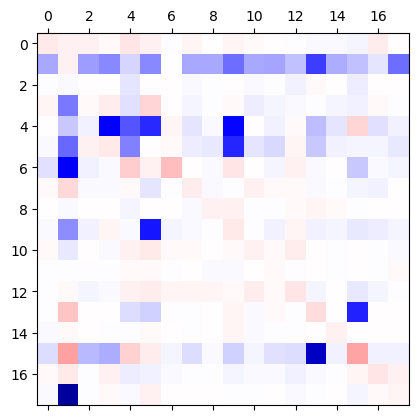

In [362]:
plt.matshow(decoder_glm.linear.weight.detach(), vmin=-1, vmax=1, cmap="seismic")

## 6 HMMGLM

In [293]:
decoder_hmmglm = naive.HMMGLM(
    n_states=n_states,
    n_neurons=n_neurons,
    kernel_size=kernel_size,
    activation="softplus",  # or "sigmoid", etc
)

In [ ]:
def train_hmmglm(
    decoder: naive.HMMGLM,
    optimizer: torch.optim.Optimizer,
    spikes: torch.FloatTensor,
    n_epochs: int = 100,
    forward_backward_every_n_epochs: int = 1,
    print_freq: int = 1,
) -> torch.FloatTensor:
    
    n_trials, n_time_bins, n_neurons = spikes.shape

    gamma_list = [None for _ in range(n_trials)]
    xi_list = [None for _ in range(n_trials)]

    df_log = pd.DataFrame(index=range(n_epochs), columns=["loss", "conditional_log_prob", "expected_log_prob"])

    for epoch in range(n_epochs):
        for trial in range(n_trials):
            x = spikes[trial]  # (n_time_bins, n_neurons)
            x_pred_mean = decoder(x)  # (n_states, n_time_bins, n_neurons)
            emission_log_prob = distributions.poisson_log_likelihood(
                x[None, :, :], x_pred_mean
            ).sum(dim=-1).T  # (n_time_bins, n_states)

            if epoch % forward_backward_every_n_epochs == 0:
                gamma_list[trial], xi_list[trial] = inference.forward_backward(
                    emission_log_prob, decoder.transition_matrix, algorithm="logsumexp"
                )
            
            expected_log_prob = (
                    inference.baum_welch(
                    emission_log_prob,
                    decoder.transition_matrix,
                    gamma_list[trial],
                    xi_list[trial],
                )
                / x.shape[0]
            )

            loss = -expected_log_prob
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            df_log.at[epoch, "loss"] = loss.item() / n_trials
            df_log.at[epoch, "conditional_log_prob"] = (
                emission_log_prob[torch.arange(n_time_bins), gamma_list[trial].argmax(dim=-1)].sum().item() / n_trials
            )
            df_log.at[epoch, "expected_log_prob"] = expected_log_prob.item() / n_trials
        
        if epoch % print_freq == 0:
            print(epoch, df_log.loc[epoch], flush=True)
    
    return df_log

In [296]:
optimizer = torch.optim.AdamW(
    decoder_hmmglm.parameters(),
    lr=5e-3,
)
n_epochs = 100
forward_backward_every_n_epochs = 4

In [297]:
df_log = train_hmmglm(
    decoder_hmmglm,
    optimizer,
    spikes,
    n_epochs=n_epochs,
    forward_backward_every_n_epochs=forward_backward_every_n_epochs,
    print_freq=1,
)

0 loss                   0.11199
test_ll             -83.734474
expected_log_prob     -0.11199
Name: 0, dtype: object
1 loss                  0.098869
test_ll             -73.948821
expected_log_prob    -0.098869
Name: 1, dtype: object
2 loss                  0.094906
test_ll             -71.007012
expected_log_prob    -0.094906
Name: 2, dtype: object
3 loss                  0.092978
test_ll             -69.579789
expected_log_prob    -0.092978
Name: 3, dtype: object
4 loss                  0.091272
test_ll             -67.203288
expected_log_prob    -0.091272
Name: 4, dtype: object
5 loss                  0.090299
test_ll             -66.497396
expected_log_prob    -0.090299
Name: 5, dtype: object
6 loss                  0.089677
test_ll             -66.037842
expected_log_prob    -0.089677
Name: 6, dtype: object
7 loss                  0.089218
test_ll             -65.697614
expected_log_prob    -0.089218
Name: 7, dtype: object
8 loss                   0.08857
test_ll             -65

Text(0.5, 0.01, 'Epoch')

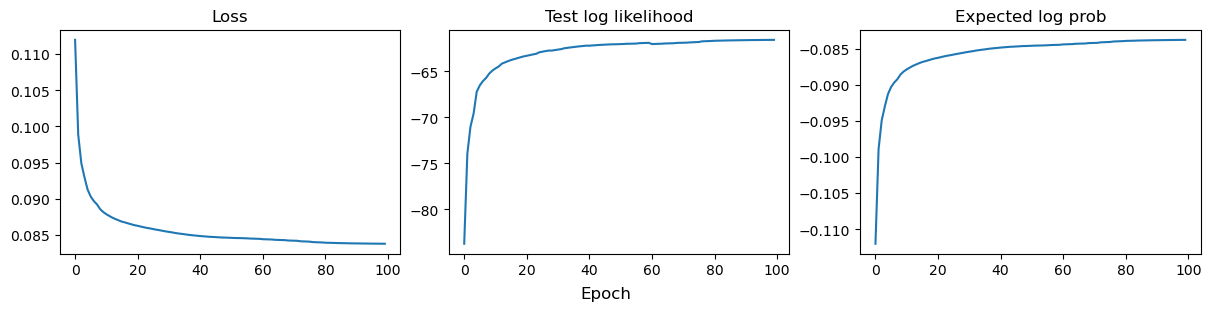

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3), layout="constrained")
axs[0].plot(df_log["loss"])
axs[0].set_title("Loss")
axs[1].plot(df_log["conditional_log_prob"])
axs[1].set_title("Conditional log prob")
axs[2].plot(df_log["expected_log_prob"])
axs[2].set_title("Expected log prob")
fig.supxlabel("Epoch")

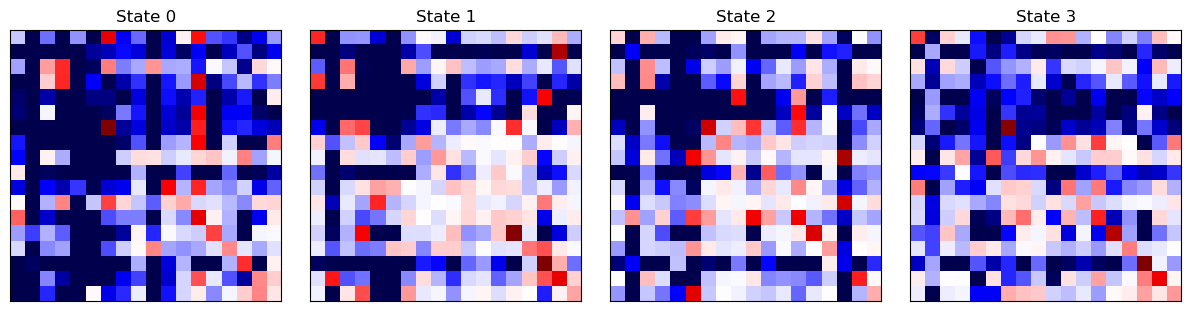

In [299]:
with torch.no_grad():
    decoder_hmmglm.eval()
    weight = decoder_hmmglm.conv.weight.sum(dim=-1).reshape(n_states, n_neurons, n_neurons)

    fig, axs = plt.subplots(1, 4, figsize=(12, 3), layout="constrained")
    for state in range(n_states):
        ax = axs[state]
        ax.matshow(weight[state], vmin=-5, vmax=5, cmap="seismic")
        ax.set_title(f"State {state}")
        ax.set(xticks=[], yticks=[])

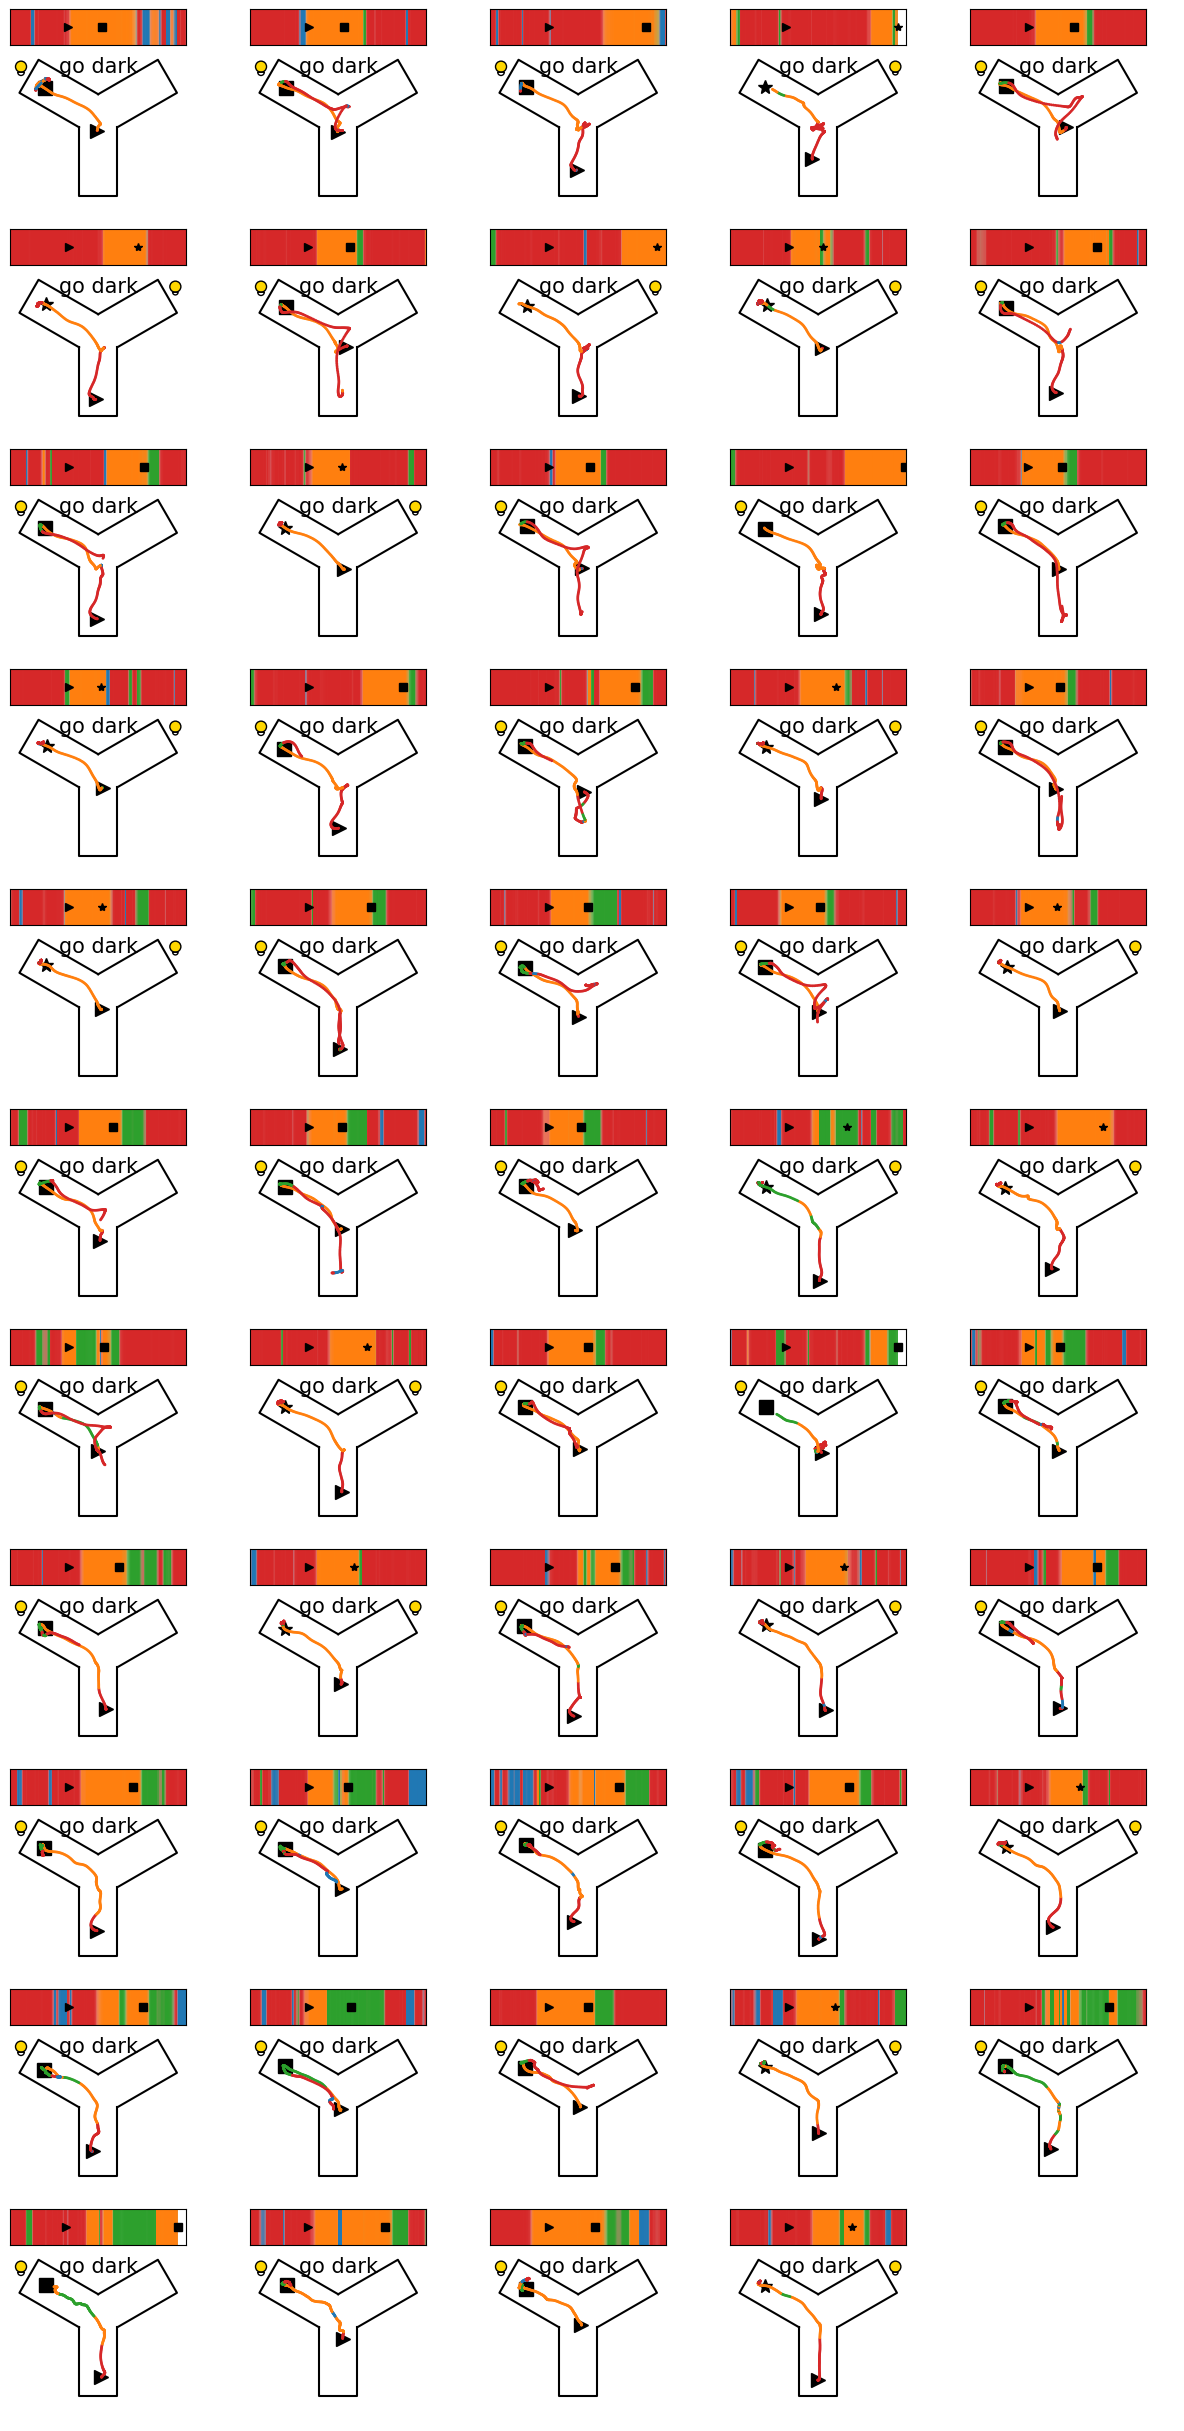

In [300]:
n_rows = (n_trials - 1) // 5 + 1
n_points = 450
fig, axs = plt.subplots(n_rows, 5, figsize=(12, 2.2 * n_rows), layout="constrained")
axs = axs.flatten()

gamma_list = [None for _ in range(n_trials)]
inferred_states_list = [None for _ in range(n_trials)]

with torch.no_grad():
    for trial in range(n_trials):
    # for trial in range(5):
        x = spikes[trial]  # (n_time_bins, n_neurons)
        x_pred_mean = decoder_hmmglm(x)  # (n_states, n_time_bins, n_neurons)
        emission_log_prob = distributions.poisson_log_likelihood(
            x[None, :, :], x_pred_mean
        ).sum(dim=-1).T  # (n_time_bins, n_states)

        gamma_list[trial], _ = inference.forward_backward(
            emission_log_prob, decoder_hmmglm.transition_matrix, algorithm="logsumexp"
        )
        inferred_states_list[trial] = inference.viterbi(
            emission_log_prob, decoder_hmmglm.transition_matrix
        )
        ax = axs[trial]
        plot_frame(ax)
        plot_trajectory(ax, behavior.loc[trial], inferred_states_list[trial], n_points=n_points, truncate=(150, -1))
        ax_divider = make_axes_locatable(ax)
        ax_states = ax_divider.append_axes("top", size="20%", pad=0)
        plot_soft_states(ax_states, behavior.loc[trial], gamma_list[trial])


    for trial in range(n_trials, len(axs)):
        axs[trial].axis("off")